In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.util import img_as_ubyte

from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

In [2]:
original_df = pd.read_csv('../data/17k-apple-app-store-strategy-games.zip', compression='zip')

In [3]:
df = pd.read_csv('../data/17k-apple-app-store-strategy-games.zip', compression='zip')

In [4]:
def show_img(url):
    imshow(resize(imread(url, as_gray=True), (64, 64)))

In [5]:
le = LabelEncoder()
rfc = RandomForestClassifier()
rfc_original = RandomForestClassifier()

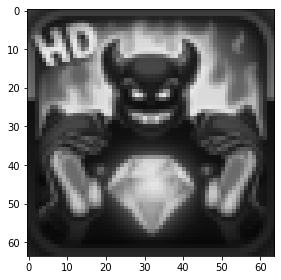

In [6]:
show_img(df['Icon URL'][1000])

In [7]:
df = df[df['Languages'].notna()]
df = df[df['Price'].notna()]
df = df[df['Average User Rating'].notna()]

In [8]:
def label_encode_purchasable(purchasables): 
    if type(purchasables) == type(np.nan):
        return 0
    
    elif len(purchasables.split(', ')) == 1:
        return 1
    
    else:
        return 2

In [9]:
df['In-app Purchases'] = df['In-app Purchases'].apply(label_encode_purchasable)

In [10]:
def label_encode_age(rating):
    if rating == '4+':
        return 0
    
    elif rating == '9+':
        return 1
    
    elif rating == '12+':
        return 2
    
    else:
        return 3

In [11]:
df['Age Rating'] = df['Age Rating'].apply(label_encode_age)

In [12]:
df['Size'] = df['Size'].apply(lambda x: int(x >= 100000000))

In [13]:
df['Languages'] = df['Languages'].apply(lambda x: int(len(x.split(', ')) > 1))

In [14]:
def is_successful(r_df):
    return int(r_df['Average User Rating'] >= 4.0 and r_df['User Rating Count'] >= 1000)

In [15]:
df['Label'] = df.apply(is_successful, axis=1)

In [16]:
prepared_no_ohe = df.drop(['URL', 'ID', 'Name', 'Subtitle', 'Icon URL', 'Average User Rating', 'User Rating Count', 'Description', 'Developer', 'Original Release Date', 'Current Version Release Date', 'Primary Genre', 'Genres'], axis=1)

In [17]:
prepared = prepared_no_ohe.join(pd.get_dummies(df['Primary Genre']))

In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    prepared.drop('Label', axis=1), prepared['Label']
)

In [19]:
from collections import Counter

In [20]:
rfc.fit(X_train, y_train)

/home/kevin/.local/share/virtualenvs/data_playground-f1s6XS9B/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

These are the accuracy and correlations after a bit of data wrangling

In [21]:
roc_auc_score(y_test, [p[1] for p in rfc.predict_proba(X_test)])

0.736748479035883

In [22]:
np.mean(rfc.predict(X_test) == y_test)

0.8652519893899204

In [23]:
Counter(rfc.predict(X_test)), Counter(y_test)

(Counter({0: 5596, 1: 56}),
 Counter({'Price': 1,
          'In-app Purchases': 1,
          'Age Rating': 1,
          'Languages': 1,
          'Size': 1,
          'Book': 1,
          'Business': 1,
          'Education': 1,
          'Entertainment': 1,
          'Finance': 1,
          'Food & Drink': 1,
          'Games': 1,
          'Health & Fitness': 1,
          'Lifestyle': 1,
          'Medical': 1,
          'Music': 1,
          'Navigation': 1,
          'News': 1,
          'Productivity': 1,
          'Reference': 1,
          'Shopping': 1,
          'Social Networking': 1,
          'Sports': 1,
          'Stickers': 1,
          'Travel': 1,
          'Utilities': 1}))

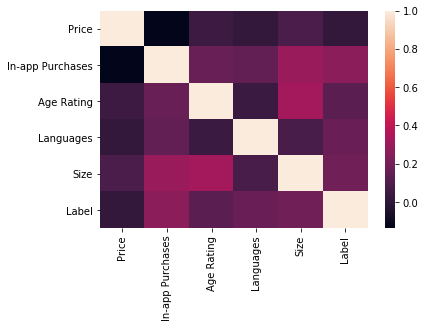

In [24]:
sns.heatmap(prepared_no_ohe.corr())

These are the original unwrangled predictions

In [25]:
original_df['Label'] = original_df['Average User Rating'].apply(lambda x: int(x >= 4.0))

In [26]:
prepared = original_df.drop(['URL', 'Name', 'Subtitle', 'Languages', 'Age Rating', 'In-app Purchases', 'Icon URL', 'Average User Rating', 'User Rating Count', 'Description', 'Developer', 'Original Release Date', 'Current Version Release Date', 'Primary Genre', 'Genres'], axis=1)

In [27]:
prepared = prepared.dropna()

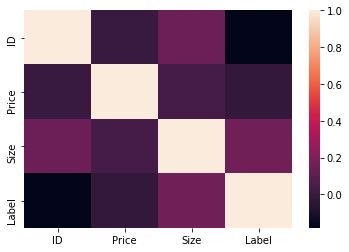

In [28]:
sns.heatmap(prepared.corr())

In [29]:
X_train, X_test, y_train, y_test = train_test_split(
    prepared.drop('Label', axis=1), prepared['Label']
)

In [30]:
rfc_original.fit(X_train, y_train)

/home/kevin/.local/share/virtualenvs/data_playground-f1s6XS9B/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [31]:
roc_auc_score(y_test, [p[1] for p in rfc_original.predict_proba(X_test)])

0.6607846782812951

In [32]:
Counter(rfc_original.predict(X_test)), Counter(y_test)

(Counter({1: 1023, 0: 3223}), Counter({0: 2878, 1: 1368}))

In [33]:
np.mean(rfc_original.predict(X_test) == y_test)

0.6799340555817239

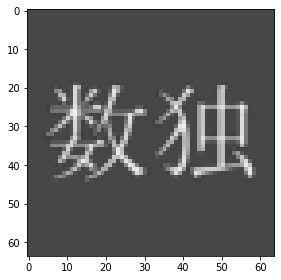

In [34]:
show_img(df['Icon URL'][0])